# construct training data from CAMELS

In [1]:
import os
import h5py 
import numpy as np

In [2]:
import corner as DFM
# --- plotting --- 
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

## load CAMELS-TNG dataset

In [3]:
dat_dir = '/tigress/chhahn/cgpop/'
f = h5py.File(os.path.join(dat_dir, 'tng.snap33.subfind.galaxies.LHC.hdf5'), 'r')
props = f['props'][...].T
f.close()

In [4]:
# Om, s8, Asn1, Aagn1, Asn2, Aagn2, Mg, Mstar, Mbh, Mtot, Vmax, Vdisp, Zg, Zs, SFR, J, Vel, Rstar, Rtot, Rvmax,
# absmag U, B, V, K, g, r, i, z
lbls = [r'$\Omega_m$', r'$\sigma_8$', r'$\log A_{\rm SN1}$', r'$\log A_{\rm AGN1}$', 
        r'$\log A_{\rm SN2}$', r'$\log A_{\rm AGN2}$', 
        r'$\log M_g$', r'$\log M_*$', r'$M_{\rm BH}$', r'$M_{\rm tot}$', r'$\log V_{\rm max}$', r'$V_{\rm disp}$', 
        r'$Z_g$', r'$\log Z_*$', 'SFR', 'J', 'V', r'$\log R_*$', r'$R_{\rm tot}$', r'$R_{\rm vmax}$', 
        r'$U$ absmag', r'$B$ absmag', r'$V$ absmag', r'$K$ absmag', r'$g$ absmag', r'$r$ absmag', r'$i$ absmag', 
        r'$z$ absmag']

$A_{\rm SN1}, A_{\rm SN2}, A_{\rm AGN1}, A_{\rm AGN2}$ are log-uniform

In [5]:
props[:,2] = np.log10(props[:,2])
props[:,3] = np.log10(props[:,3])
props[:,4] = np.log10(props[:,4])
props[:,5] = np.log10(props[:,5])

props[:,6] = np.log10(props[:,6])
props[:,7] = np.log10(props[:,7])
props[:,10] = np.log10(props[:,10])
props[:,13] = np.log10(props[:,13])
props[:,17] = np.log10(props[:,17])

/home/chhahn/.conda/envs/sbi/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log10
  


In [6]:
icosmo = [0, 1, 2, 3, 4, 5] # cosmological/hydro parameters
igals = [6, 7, 10, 13, 17] # intrinsic properties of galaixes (Mg, M*, Vmax, Z*, R*)
iobs = [-4, -3, -2, -1] # g, r, i, z absolute magnitudes

## importance weight $p(\Omega, \mathcal{B})$

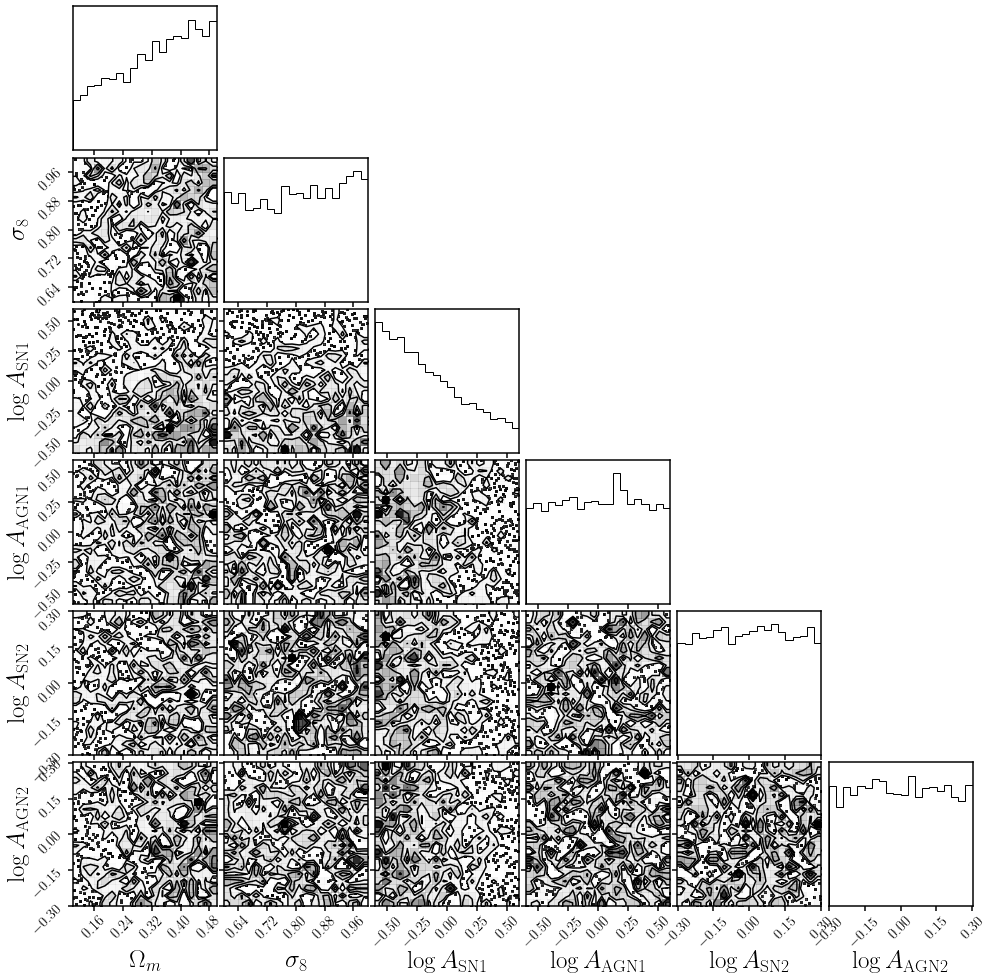

In [7]:
fig = DFM.corner(props[:,icosmo], 
                 labels=[lbls[i] for i in icosmo], label_kwargs={'fontsize': 25})

In [8]:
ikeep = [] 
w_lhc = np.ones(props.shape[0])
for lhc in np.unique(np.sum(props[:,icosmo], axis=1)):
    is_lhc = (np.sum(props[:,icosmo], axis=1) == lhc)
    
    N_lhc = np.sum(is_lhc)
    
    w_lhc[is_lhc] = 100./float(N_lhc)
    
    ikeep.append(np.random.choice(np.arange(props.shape[0])[is_lhc], size=100, replace=False))
ikeep = np.concatenate(ikeep)

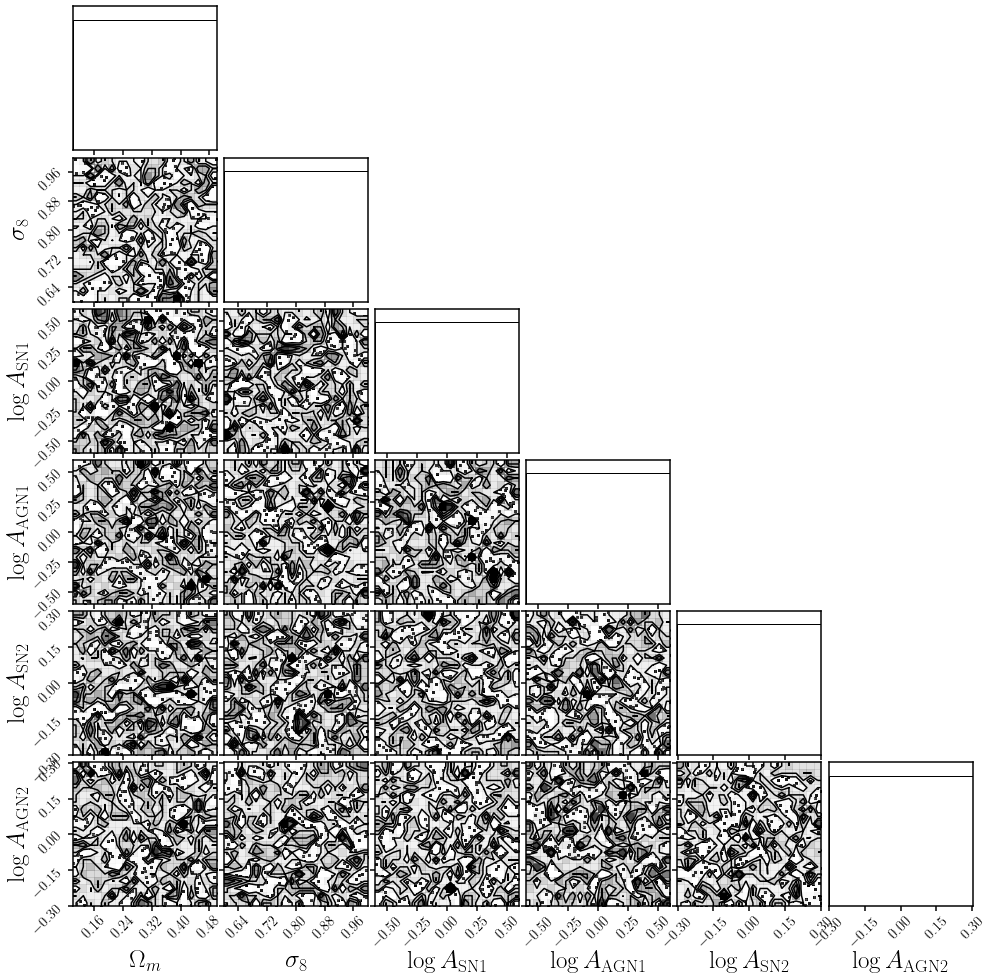

In [9]:
fig = DFM.corner(props[:,icosmo], weights=w_lhc, 
                 labels=[lbls[i] for i in icosmo], label_kwargs={'fontsize': 25})

# forward model photometry

In [10]:
absmag_sigmas = np.random.uniform(0.019, 0.023, size=(props.shape[0], len(iobs)))
absmag_sigmas[:,-1] = np.random.uniform(0.029, 0.041, size=props.shape[0])
absmags = props[:,np.array(iobs)] + absmag_sigmas * np.random.normal(size=(props.shape[0], len(iobs)))

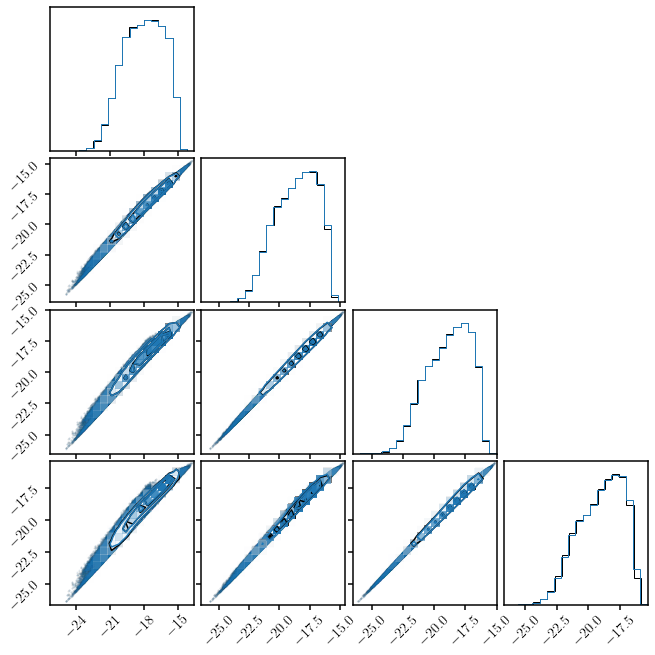

In [11]:
fig = DFM.corner(props[:,iobs], color='k')
_ = DFM.corner(absmags, color='C0', fig=fig)

# save to ascii file for convenience

In [12]:
ftrain = os.path.join(dat_dir, 'camels_tng.omega_thetag.dat')
hdr = ('name: Omega_m, sigma_8, log A_SN1, log A_AGN1, log A_SN2, log A_AGN2, '+
       'log M_g, log M_*, log V_max, log Z_*, log R_*, w_lhc')
np.savetxt(ftrain, np.concatenate([props[:,icosmo], props[:,igals], w_lhc[:,None]], axis=1), header=hdr)

In [13]:
ftrain = os.path.join(dat_dir, 'camels_tng.omega_thetag.down.dat')
hdr = ('name: Omega_m, sigma_8, log A_SN1, log A_AGN1, log A_SN2, log A_AGN2, '+
       'log M_g, log M_*, log V_max, log Z_*, log R_*')
np.savetxt(ftrain, np.concatenate([props[:,icosmo], props[:,igals]], axis=1)[ikeep], header=hdr)

In [14]:
ftrain = os.path.join(dat_dir, 'camels_tng.omega_x.dat')
hdr = ('name: Omega_m, sigma_8, log A_SN1, log A_AGN1, log A_SN2, log A_AGN2, '+
       'g absmag, r absmag, i, absmag, z absmag, sigma_g, sigma_r, sigma_i, sigma_z, w_lhc')
np.savetxt(ftrain, np.concatenate([props[:,icosmo], absmags, absmag_sigmas, w_lhc[:,None]], axis=1), header=hdr)

In [15]:
ftrain = os.path.join(dat_dir, 'camels_tng.omega_x.down.dat')
hdr = ('name: Omega_m, sigma_8, log A_SN1, log A_AGN1, log A_SN2, log A_AGN2, '+
       'g absmag, r absmag, i, absmag, z absmag, sigma_g, sigma_r, sigma_i, sigma_z')
np.savetxt(ftrain, np.concatenate([props[:,icosmo], absmags, absmag_sigmas], axis=1)[ikeep], header=hdr)

# CAMELS-SIMBA

In [3]:
dat_dir = '/tigress/chhahn/cgpop/'
f = h5py.File(os.path.join(dat_dir, 'simba.snap33.subfind.galaxies.LHC.hdf5'), 'r')
props = f['props'][...].T
f.close()

In [4]:
# Om, s8, Asn1, Aagn1, Asn2, Aagn2, Mg, Mstar, Mbh, Mtot, Vmax, Vdisp, Zg, Zs, SFR, J, Vel, Rstar, Rtot, Rvmax,
# absmag U, B, V, K, g, r, i, z
lbls = [r'$\Omega_m$', r'$\sigma_8$', r'$\log A_{\rm SN1}$', r'$\log A_{\rm AGN1}$', 
        r'$\log A_{\rm SN2}$', r'$\log A_{\rm AGN2}$', 
        r'$\log M_g$', r'$\log M_*$', r'$M_{\rm BH}$', r'$M_{\rm tot}$', r'$\log V_{\rm max}$', r'$V_{\rm disp}$', 
        r'$Z_g$', r'$\log Z_*$', 'SFR', 'J', 'V', r'$\log R_*$', r'$R_{\rm tot}$', r'$R_{\rm vmax}$', 
        r'$U$ absmag', r'$B$ absmag', r'$V$ absmag', r'$K$ absmag', r'$g$ absmag', r'$r$ absmag', r'$i$ absmag', 
        r'$z$ absmag']

In [5]:
props[:,2] = np.log10(props[:,2])
props[:,3] = np.log10(props[:,3])
props[:,4] = np.log10(props[:,4])
props[:,5] = np.log10(props[:,5])

props[:,6] = np.log10(props[:,6])
props[:,7] = np.log10(props[:,7])
props[:,10] = np.log10(props[:,10])
props[:,13] = np.log10(props[:,13])
props[:,17] = np.log10(props[:,17])

/home/chhahn/.conda/envs/sbi/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log10
  


In [6]:
icosmo = [0, 1, 2, 3, 4, 5] # cosmological/hydro parameters
igals = [6, 7, 10, 13, 17] # intrinsic properties of galaixes (Mg, M*, Vmax, Z*, R*)
iobs = [-4, -3, -2, -1] # g, r, i, z absolute magnitudes

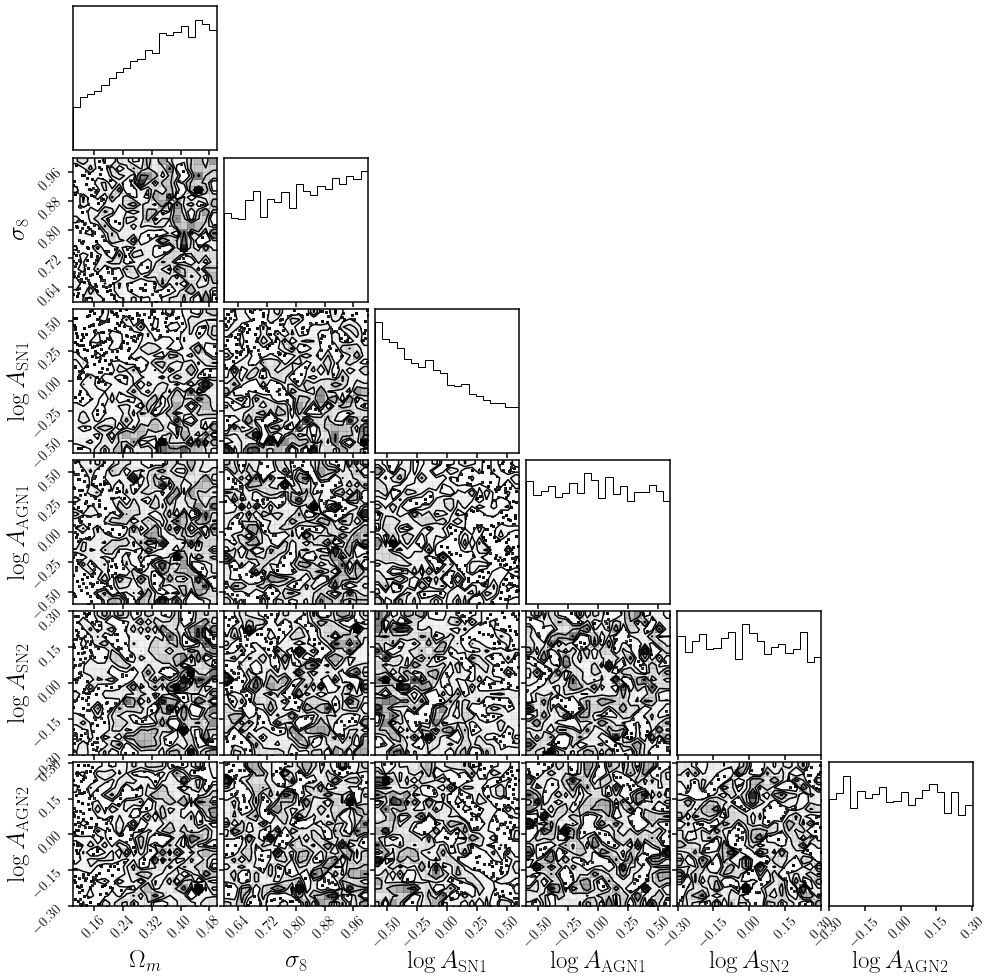

In [7]:
fig = DFM.corner(props[:,icosmo], 
                 labels=[lbls[i] for i in icosmo], label_kwargs={'fontsize': 25})

In [8]:
ikeep = [] 
w_lhc = np.ones(props.shape[0])
for lhc in np.unique(np.sum(props[:,icosmo], axis=1)):
    is_lhc = (np.sum(props[:,icosmo], axis=1) == lhc)
    
    N_lhc = np.sum(is_lhc)
    
    w_lhc[is_lhc] = 100./float(N_lhc)
    
    ikeep.append(np.random.choice(np.arange(props.shape[0])[is_lhc], size=100, replace=False))
ikeep = np.concatenate(ikeep)

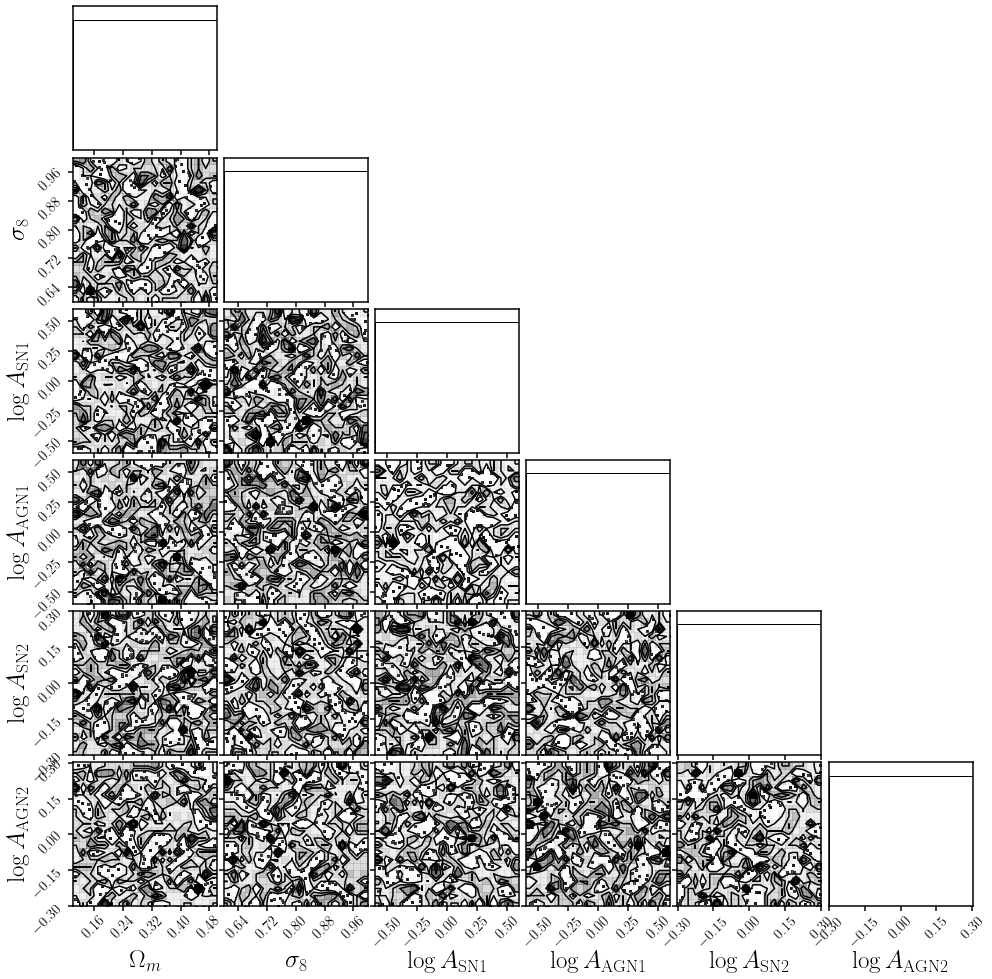

In [9]:
fig = DFM.corner(props[:,icosmo], weights=w_lhc, 
                 labels=[lbls[i] for i in icosmo], label_kwargs={'fontsize': 25})

In [15]:
ftrain = os.path.join(dat_dir, 'camels_simba.omega_thetag.dat')
hdr = ('name: Omega_m, sigma_8, log A_SN1, log A_AGN1, log A_SN2, log A_AGN2, '+
       'log M_g, log M_*, log V_max, log Z_*, log R_*, w_lhc')
np.savetxt(ftrain, np.concatenate([props[:,icosmo], props[:,igals], w_lhc[:,None]], axis=1), header=hdr)

In [18]:
ftrain = os.path.join(dat_dir, 'camels_simba.omega_thetag.down.dat')
hdr = ('name: Omega_m, sigma_8, log A_SN1, log A_AGN1, log A_SN2, log A_AGN2, '+
       'log M_g, log M_*, log V_max, log Z_*, log R_*')
np.savetxt(ftrain, np.concatenate([props[:,icosmo], props[:,igals]], axis=1)[ikeep], header=hdr)